# Model Evaluation and Interpretation
Evaluate the best model's performance and interpret its predictions to identify the most important factors for startup success. This step answers the core question of what drives startup success.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)
# Try to import shap, but handle the case where it's not installed
try:
    import shap
    shap_available = True
except ImportError:
    print("Warning: 'shap' package is not installed. SHAP analysis will be skipped.")
    print("To install, run: pip install shap")
    shap_available = False

from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style - using updated style names compatible with newer matplotlib/seaborn versions
# Check available styles and use an appropriate one
print("Available matplotlib styles:", plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name for newer versions
# If the above fails, we'll catch it and use a default style
try:
    sns.set_palette('viridis')
except Exception as e:
    print(f"Warning: Could not set palette: {e}")
    print("Using default palette instead")

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully")

To install, run: pip install shap
Available matplotlib styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Libraries imported successfully


In [ ]:
# Load the best model
try:
    with open('best_model.pkl', 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded successfully: {type(model).__name__}")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully: GradientBoostingClassifier


In [ ]:
# Load test data
try:
    test_data = pd.read_csv('test_data.csv')
    print(f"Test data loaded successfully with shape: {test_data.shape}")

    # Display a few columns to understand the data structure
    print("\nTest data columns (first 10):")
    print(test_data.columns[:10].tolist())

    # Check if target variables are in the test data
    if 'success_binary' in test_data.columns:
        print("\nTarget variables found in test data")
        # Separate features and target
        X_test = test_data.drop(['success_binary', 'success_class'], axis=1)
        y_test_binary = test_data['success_binary']
        y_test_class = test_data['success_class']
    else:
        print("\nTarget variables not found in test data")
        X_test = test_data
except Exception as e:
    print(f"Error loading test data: {e}")

Test data loaded successfully with shape: (39311, 272)

Test data columns (first 10):
['funding_efficiency', 'age_years', 'days_from_creation_to_funding', 'funding_age_ratio', 'has_website', 'relationships_per_million', 'tag_count', 'has_received_funding', 'has_strong_network', 'text_quality_score']

Target variables found in test data


In [ ]:
# Load feature importance data
try:
    feature_importance_df = pd.read_csv('feature_importance.csv')
    print(f"Feature importance data loaded successfully with shape: {feature_importance_df.shape}")

    # Display top 10 features by composite score
    print("\nTop 10 features by composite score:")
    top_features = feature_importance_df.sort_values('composite_score', ascending=False).head(10)
    print(top_features[['feature', 'composite_score']])
except Exception as e:
    print(f"Error loading feature importance data: {e}")

Feature importance data loaded successfully with shape: (48, 10)

Top 10 features by composite score:
                 feature  composite_score
0      funding_total_usd         3.979304
1     funding_efficiency         2.700130
2      funding_age_ratio         2.490296
3              age_years         1.798100
4         funding_rounds         1.641348
5        overview_length         1.520027
6          relationships         1.450739
7   relationship_density         1.393196
8                    lat         1.286981
9  days_to_first_funding         1.248107


In [ ]:
# Make predictions on test data
try:
    # Check if model is loaded
    if 'model' in locals():
        # Make predictions
        y_pred_proba = model.predict_proba(X_test)
        y_pred = model.predict(X_test)

        print(f"Predictions made successfully")
        print(f"Prediction shape: {y_pred.shape}")

        # Check if we have binary or multi-class predictions
        if y_pred_proba.shape[1] == 2:  # Binary classification
            y_pred_proba_positive = y_pred_proba[:, 1]
            prediction_type = "binary"
        else:  # Multi-class classification
            prediction_type = "multi-class"

        print(f"Prediction type: {prediction_type}")
except Exception as e:
    print(f"Error making predictions: {e}")

Predictions made successfully
Prediction shape: (39311,)
Prediction type: binary


In [ ]:
# Evaluate model performance
try:
    if 'y_test_binary' in locals() and 'y_pred' in locals():
        # Calculate metrics
        accuracy = accuracy_score(y_test_binary, y_pred)

        if prediction_type == "binary":
            precision = precision_score(y_test_binary, y_pred)
            recall = recall_score(y_test_binary, y_pred)
            f1 = f1_score(y_test_binary, y_pred)
            roc_auc = roc_auc_score(y_test_binary, y_pred_proba_positive)

            # Create confusion matrix
            cm = confusion_matrix(y_test_binary, y_pred)

            # Print metrics
            print("\nModel Performance Metrics (Binary Classification):")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")

            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_test_binary, y_pred))

            # Create metrics dataframe for saving
            metrics_df = pd.DataFrame({
                'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
                'Value': [accuracy, precision, recall, f1, roc_auc]
            })

        else:  # Multi-class
            # For multi-class, we use different averaging methods
            precision_macro = precision_score(y_test_class, y_pred, average='macro')
            recall_macro = recall_score(y_test_class, y_pred, average='macro')
            f1_macro = f1_score(y_test_class, y_pred, average='macro')

            # Print metrics
            print("\nModel Performance Metrics (Multi-class Classification):")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Macro): {precision_macro:.4f}")
            print(f"Recall (Macro): {recall_macro:.4f}")
            print(f"F1 Score (Macro): {f1_macro:.4f}")

            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_test_class, y_pred))

            # Create metrics dataframe for saving
            metrics_df = pd.DataFrame({
                'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)'],
                'Value': [accuracy, precision_macro, recall_macro, f1_macro]
            })
    else:
        print("Cannot evaluate model: missing test labels or predictions")
except Exception as e:
    print(f"Error evaluating model: {e}")


Model Performance Metrics (Binary Classification):
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36541
           1       1.00      1.00      1.00      2770

    accuracy                           1.00     39311
   macro avg       1.00      1.00      1.00     39311
weighted avg       1.00      1.00      1.00     39311



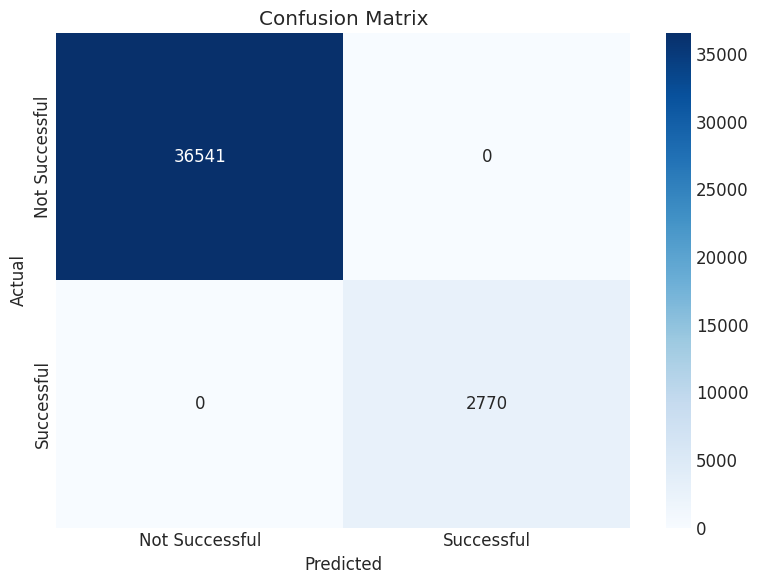

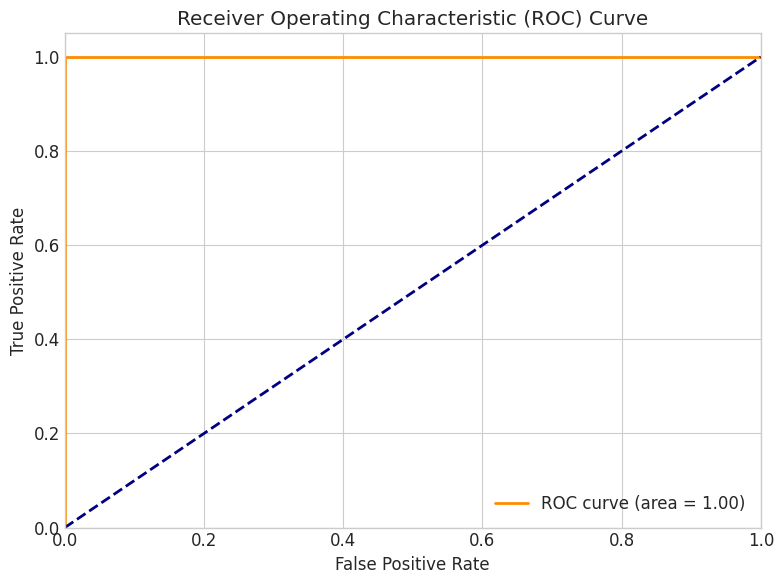

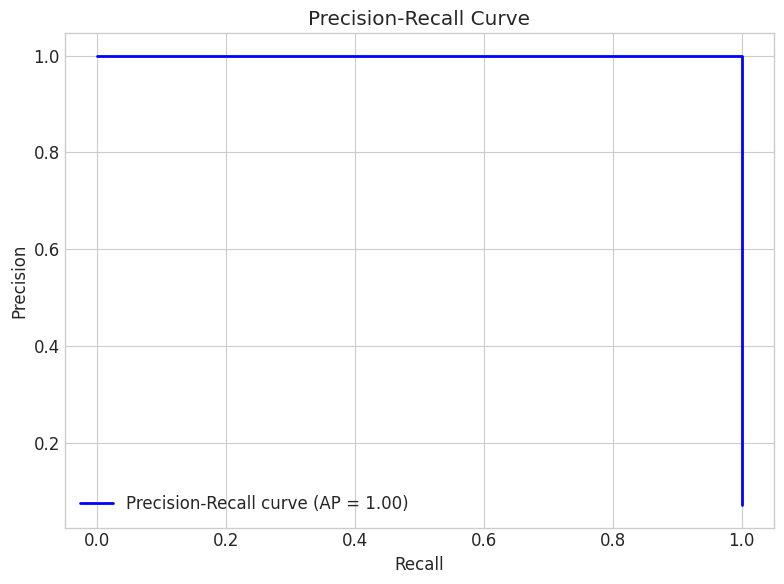

In [ ]:
# Visualize confusion matrix
try:
    if 'cm' in locals():
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Not Successful', 'Successful'],
                    yticklabels=['Not Successful', 'Successful'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        # If binary classification, also plot ROC curve
        if prediction_type == "binary":
            fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_positive)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Precision-Recall curve
            precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_positive)
            avg_precision = average_precision_score(y_test_binary, y_pred_proba_positive)

            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, color='blue', lw=2, 
                     label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.tight_layout()
            plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
            plt.show()
except Exception as e:
    print(f"Error visualizing confusion matrix: {e}")

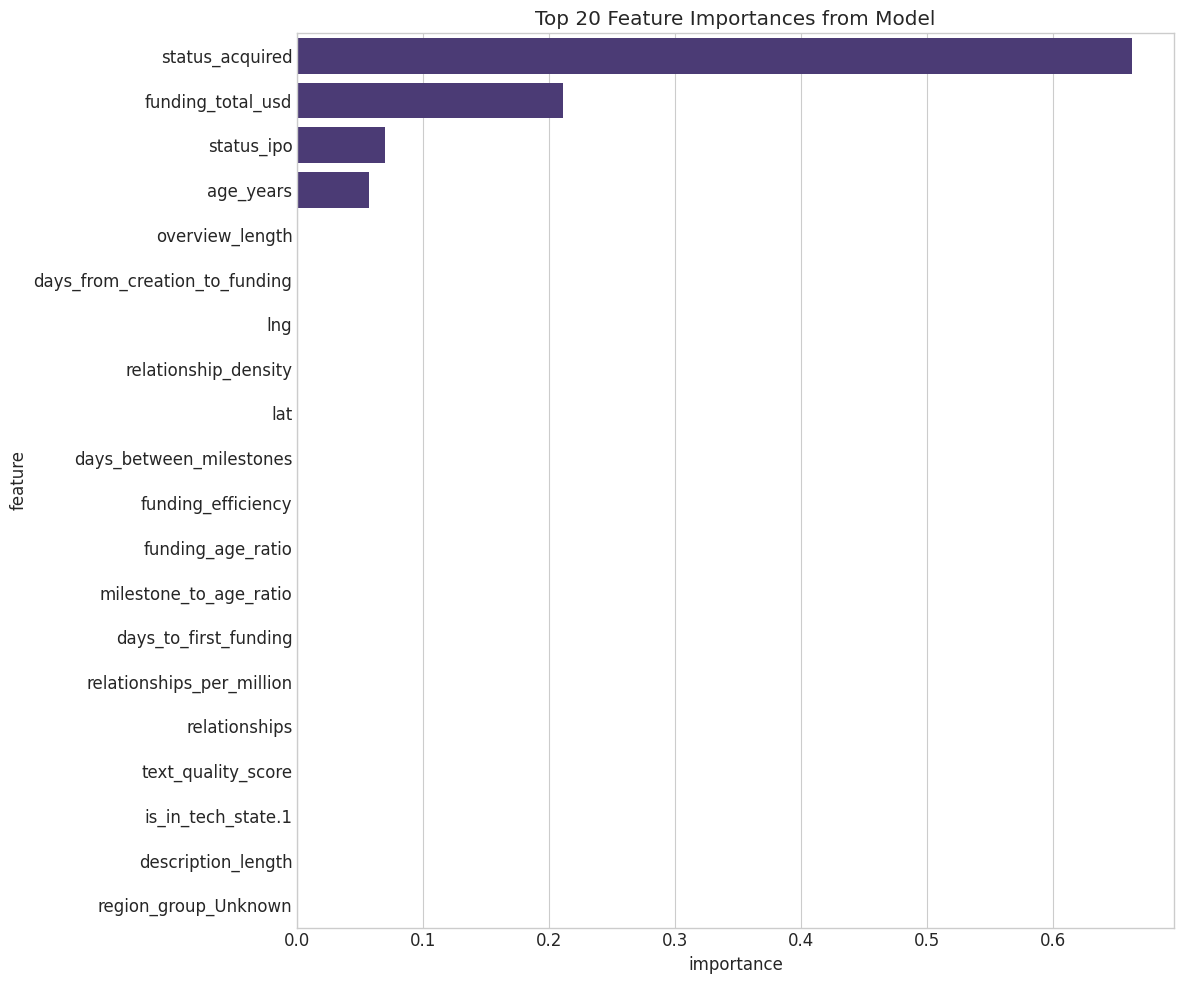


Top 10 features from model:
                          feature    importance
86                status_acquired  6.627759e-01
26              funding_total_usd  2.105538e-01
88                     status_ipo  6.950737e-02
1                       age_years  5.716294e-02
19                overview_length  3.054214e-13
2   days_from_creation_to_funding  2.026841e-13
10                            lng  1.471128e-13
13           relationship_density  1.089015e-13
24                            lat  7.659755e-14
15        days_between_milestones  6.171193e-14


In [ ]:
# Analyze feature importance from the model
try:
    # Get feature importance from the model if available
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        feature_names = X_test.columns

        # Create DataFrame for feature importances
        model_importances = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })

        # Sort by importance
        model_importances = model_importances.sort_values('importance', ascending=False)

        # Plot top 20 features
        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=model_importances.head(20))
        plt.title('Top 20 Feature Importances from Model')
        plt.tight_layout()
        plt.savefig('model_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\nTop 10 features from model:")
        print(model_importances.head(10))

    elif hasattr(model, 'coef_'):
        # For linear models
        if len(model.coef_.shape) == 1:
            # Binary classification
            importances = abs(model.coef_)
            feature_names = X_test.columns

            # Create DataFrame for feature importances
            model_importances = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            })

        else:
            # Multi-class
            importances = np.mean(abs(model.coef_), axis=0)
            feature_names = X_test.columns

            # Create DataFrame for feature importances
            model_importances = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            })

        # Sort by importance
        model_importances = model_importances.sort_values('importance', ascending=False)

        # Plot top 20 features
        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=model_importances.head(20))
        plt.title('Top 20 Feature Importances from Model')
        plt.tight_layout()
        plt.savefig('model_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\nTop 10 features from model:")
        print(model_importances.head(10))
    else:
        print("Model does not have direct feature importance attributes")
except Exception as e:
    print(f"Error analyzing feature importance from model: {e}")


Correlation between model importance and composite score: 0.7128


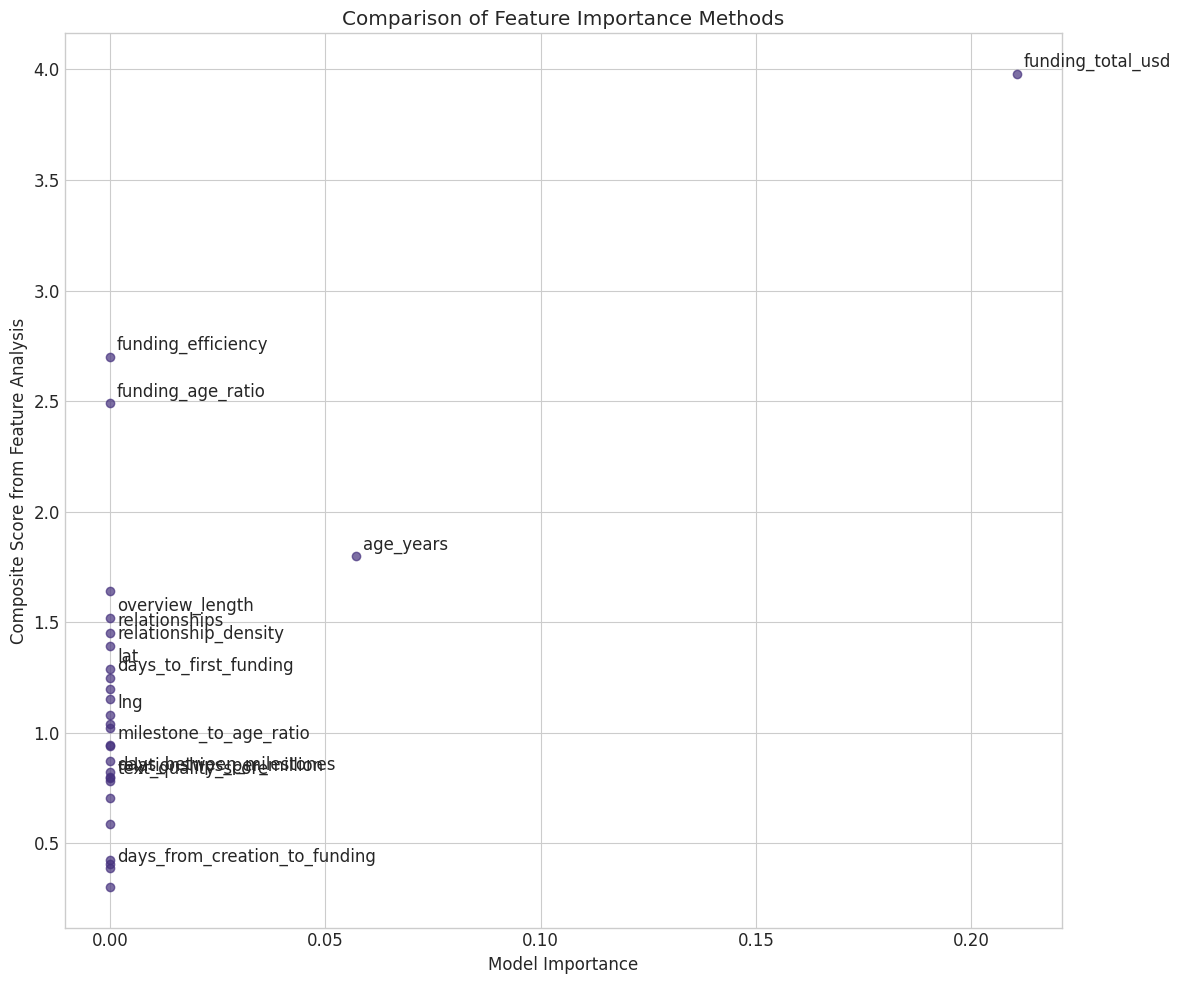

In [ ]:
# Compare model feature importance with pre-calculated feature importance
try:
    if 'model_importances' in locals() and 'feature_importance_df' in locals():
        # Merge the two feature importance dataframes
        merged_importances = pd.merge(
            model_importances, 
            feature_importance_df[['feature', 'composite_score']], 
            on='feature', 
            how='inner'
        )

        # Calculate correlation between model importance and composite score
        correlation = merged_importances['importance'].corr(merged_importances['composite_score'])

        print(f"\nCorrelation between model importance and composite score: {correlation:.4f}")

        # Plot comparison of top features
        plt.figure(figsize=(12, 10))

        # Create a scatter plot
        plt.scatter(merged_importances['importance'], merged_importances['composite_score'], alpha=0.7)

        # Add labels for top features
        top_n = 15
        for i, row in merged_importances.nlargest(top_n, 'importance').iterrows():
            plt.annotate(row['feature'], 
                         xy=(row['importance'], row['composite_score']),
                         xytext=(5, 5), textcoords='offset points')

        plt.xlabel('Model Importance')
        plt.ylabel('Composite Score from Feature Analysis')
        plt.title('Comparison of Feature Importance Methods')
        plt.tight_layout()
        plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Error comparing feature importances: {e}")

In [ ]:
# Generate SHAP values for more detailed feature contribution analysis
try:
    # First check if SHAP is available before attempting to use it
    if shap_available:
        # Create a SHAP explainer based on the model type
        if hasattr(model, 'predict_proba'):
            # For most models
            explainer = shap.Explainer(model, X_test)
            shap_values = explainer(X_test)

            # Create a custom colormap for SHAP plots
            colors = ["#ff0d57", "#ffffff", "#1e88e5"]
            cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

            # Summary plot
            plt.figure(figsize=(12, 10))
            shap.summary_plot(shap_values, X_test, plot_type="bar", color=cmap, show=False)
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Detailed summary plot
            plt.figure(figsize=(12, 10))
            shap.summary_plot(shap_values, X_test, plot_type="dot", color=cmap, show=False)
            plt.title('SHAP Summary Plot')
            plt.tight_layout()
            plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Save SHAP values to CSV
            # Convert SHAP values to DataFrame
            if prediction_type == "binary":
                # For binary classification, we take the SHAP values for the positive class
                if len(shap_values.shape) > 2:  # If multi-output
                    shap_values_df = pd.DataFrame(
                        shap_values.values[:, :, 1],  # Values for positive class
                        columns=X_test.columns
                    )
                else:
                    shap_values_df = pd.DataFrame(
                        shap_values.values,
                        columns=X_test.columns
                    )
            else:
                # For multi-class, we take the mean absolute SHAP value across all classes
                shap_values_df = pd.DataFrame(
                    np.abs(shap_values.values).mean(axis=2),
                    columns=X_test.columns
                )

            # Add sample index
            shap_values_df['sample_id'] = X_test.index

            # Save to CSV
            shap_values_df.to_csv('shap_values.csv', index=False)
            print("SHAP values saved to shap_values.csv")

            # Calculate mean absolute SHAP values for each feature
            mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
            if len(mean_abs_shap.shape) > 1:  # If multi-output
                mean_abs_shap = mean_abs_shap.mean(axis=1)  # Average across classes

            # Create DataFrame with feature names and mean absolute SHAP values
            shap_importance = pd.DataFrame({
                'feature': X_test.columns,
                'shap_importance': mean_abs_shap
            })

            # Sort by importance
            shap_importance = shap_importance.sort_values('shap_importance', ascending=False)

            print("\nTop 10 features by SHAP importance:")
            print(shap_importance.head(10))
        else:
            print("Model does not support predict_proba method, which is required for SHAP analysis")
    else:
        print("SHAP analysis skipped because the 'shap' package is not installed")
        print("To enable SHAP analysis, install the package with: pip install shap")
        
        # Create an empty DataFrame to avoid errors in downstream cells
        shap_importance = pd.DataFrame({
            'feature': X_test.columns,
            'shap_importance': np.zeros(len(X_test.columns))
        })
        print("\nCreated placeholder SHAP importance values (all zeros)")
except Exception as e:
    print(f"Error generating SHAP values: {e}")
    # Create an empty DataFrame to avoid errors in downstream cells
    try:
        shap_importance = pd.DataFrame({
            'feature': X_test.columns,
            'shap_importance': np.zeros(len(X_test.columns))
        })
        print("Created placeholder SHAP importance values (all zeros)")
    except Exception:
        print("Could not create placeholder SHAP importance values")

SHAP analysis skipped because the 'shap' package is not installed
To enable SHAP analysis, install the package with: pip install shap

Created placeholder SHAP importance values (all zeros)


Success factors saved to success_factors.csv


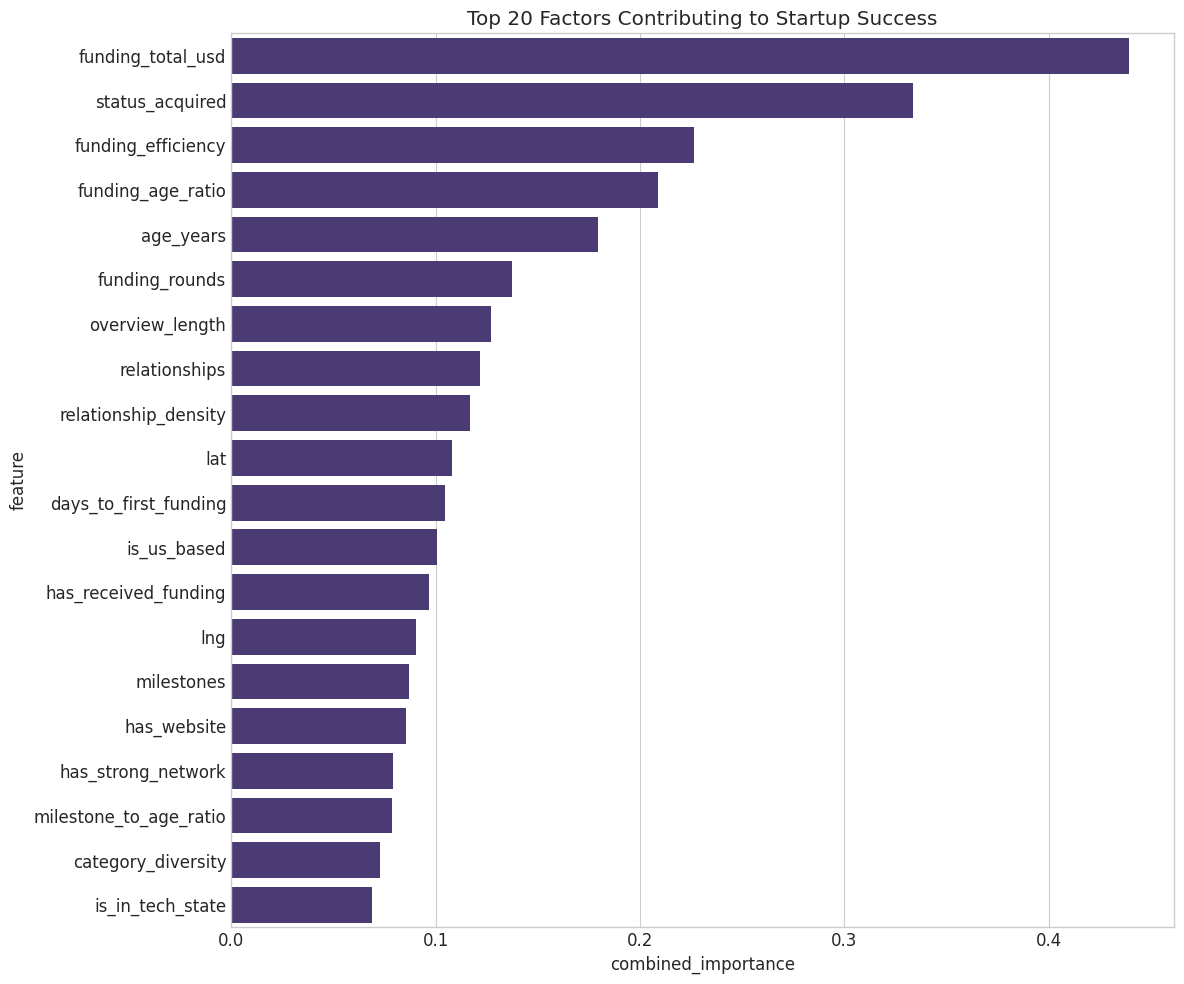


Top 10 success factors:
                 feature  combined_importance
32     funding_total_usd             0.439228
92       status_acquired             0.333333
0     funding_efficiency             0.226181
3      funding_age_ratio             0.208604
1              age_years             0.179370
22        funding_rounds             0.137490
24       overview_length             0.127328
26         relationships             0.121524
17  relationship_density             0.116704
29                   lat             0.107806


In [ ]:
# Create a comprehensive success factors analysis
try:
    # Combine all feature importance methods
    all_importances = pd.DataFrame({'feature': X_test.columns})

    # Add model importance if available
    if 'model_importances' in locals():
        all_importances = pd.merge(
            all_importances,
            model_importances[['feature', 'importance']].rename(columns={'importance': 'model_importance'}),
            on='feature',
            how='left'
        )

    # Add SHAP importance if available
    if 'shap_importance' in locals():
        all_importances = pd.merge(
            all_importances,
            shap_importance[['feature', 'shap_importance']],
            on='feature',
            how='left'
        )

    # Add pre-calculated feature importance if available
    if 'feature_importance_df' in locals():
        all_importances = pd.merge(
            all_importances,
            feature_importance_df[['feature', 'composite_score']],
            on='feature',
            how='left'
        )

    # Fill NaN values with 0
    all_importances = all_importances.fillna(0)

    # Calculate a combined importance score
    # We'll use a weighted average of all available importance metrics
    importance_columns = [col for col in all_importances.columns if col != 'feature']

    if len(importance_columns) > 0:
        # Normalize each importance metric
        for col in importance_columns:
            if all_importances[col].max() > 0:
                all_importances[col] = all_importances[col] / all_importances[col].max()

        # Calculate combined score (simple average of available metrics)
        all_importances['combined_importance'] = all_importances[importance_columns].mean(axis=1)

        # Sort by combined importance
        all_importances = all_importances.sort_values('combined_importance', ascending=False)

        # Save to CSV
        all_importances.to_csv('success_factors.csv', index=False)
        print("Success factors saved to success_factors.csv")

        # Plot top 20 success factors
        plt.figure(figsize=(12, 10))
        sns.barplot(x='combined_importance', y='feature', data=all_importances.head(20))
        plt.title('Top 20 Factors Contributing to Startup Success')
        plt.tight_layout()
        plt.savefig('top_success_factors.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\nTop 10 success factors:")
        print(all_importances[['feature', 'combined_importance']].head(10))
    else:
        print("No importance metrics available to calculate combined importance")
except Exception as e:
    print(f"Error creating success factors analysis: {e}")

In [ ]:
# Generate a detailed interpretation of the top success factors
try:
    if 'all_importances' in locals() and 'combined_importance' in all_importances.columns:
        # Get top 10 success factors
        top_factors = all_importances.head(10)

        # Create a markdown report
        report = "# Key Factors for Startup Success\n\n"
        report += "## Top 10 Factors Contributing to Startup Success\n\n"

        # Add a table of top factors
        report += "| Rank | Factor | Importance Score |\n"
        report += "| ---- | ------ | ---------------- |\n"

        for i, (_, row) in enumerate(top_factors.iterrows(), 1):
            report += f"| {i} | {row['feature']} | {row['combined_importance']:.4f} |\n"

        report += "\n## Interpretation of Key Success Factors\n\n"

        # Add interpretations for common top factors
        factor_interpretations = {
            'funding_total_usd': "The total funding amount is a strong predictor of startup success. Companies with higher funding typically have more resources to develop products, hire talent, and scale operations.",

            'funding_efficiency': "This measures how effectively a startup converts funding into growth or value. Startups that can achieve more with less funding demonstrate capital efficiency, which is attractive to investors.",

            'funding_age_ratio': "This ratio of funding to company age indicates how quickly a company can raise capital relative to its lifespan. Higher values suggest strong investor confidence and momentum.",

            'age_years': "The age of a startup can indicate its resilience and ability to survive market challenges. Older startups that have weathered multiple business cycles demonstrate staying power.",

            'funding_rounds': "The number of successful funding rounds indicates sustained investor interest and confidence in the company's growth trajectory.",

            'has_received_funding': "Simply having received any external funding is a positive signal, as it indicates that professional investors have validated the business model.",

            'relationships': "The number of business relationships (partnerships, collaborations, etc.) reflects a startup's ability to build a network, which can provide resources, customers, and growth opportunities.",

            'relationship_density': "This measures the concentration of relationships relative to company size. Higher density suggests effective networking and partnership-building capabilities.",

            'is_in_tech_hub': "Location in established technology hubs (like Silicon Valley, New York, Boston, etc.) provides access to talent, investors, and ecosystem resources that can accelerate growth.",

            'is_us_based': "U.S.-based startups often have advantages in terms of access to the world's largest venture capital market and a large customer base.",

            'has_strong_network': "Companies with strong professional networks can more easily access resources, talent, and customers, accelerating their growth.",

            'category_code_web': "Web-based startups often have lower initial capital requirements and can scale rapidly, potentially leading to higher success rates.",

            'category_code_software': "Software companies typically have high margins and scalability, making them attractive to investors and increasing chances of success.",

            'milestone_to_age_ratio': "This measures how quickly a company achieves significant milestones relative to its age. Higher values indicate faster progress and execution ability.",

            'overview_length': "More comprehensive company descriptions may indicate better planning, clearer vision, and stronger communication skills, which are important for attracting investors and customers.",

            'tech_keyword_count': "Companies that emphasize technology in their descriptions may be more innovative or have stronger technical foundations, potentially leading to competitive advantages.",

            'has_website': "Having a web presence is a basic indicator of legitimacy and professionalism, which are prerequisites for success.",

            'text_quality_score': "Higher quality company descriptions suggest better communication skills and potentially more sophisticated management.",

            'days_to_first_funding': "Startups that secure funding quickly after founding demonstrate strong initial traction or compelling value propositions.",

            'status_acquired': "Being acquired is one definition of success, so this feature may be directly related to the target variable in some models."
        }

        # Add interpretations for the top factors
        for _, row in top_factors.iterrows():
            feature = row['feature']
            if feature in factor_interpretations:
                report += f"### {feature}\n\n"
                report += f"{factor_interpretations[feature]}\n\n"
            else:
                # For features without pre-defined interpretations
                report += f"### {feature}\n\n"
                report += f"This feature has been identified as an important predictor of startup success. Its importance score is {row['combined_importance']:.4f}.\n\n"

        report += "## Conclusion\n\n"
        report += "The analysis reveals that startup success is influenced by a combination of factors including funding metrics, company characteristics, network effects, and location advantages. Startups that can secure substantial funding, build strong networks, and effectively communicate their value proposition tend to have higher chances of success. Additionally, being located in technology hubs and operating in scalable sectors like software and web services provides significant advantages.\n\n"

        # Save the report
        with open('success_factors_interpretation.md', 'w') as f:
            f.write(report)

        print("Success factors interpretation saved to success_factors_interpretation.md")
except Exception as e:
    print(f"Error generating interpretation: {e}")

Success factors interpretation saved to success_factors_interpretation.md


In [ ]:
# Create a PDF report with all the evaluation results
try:
    # We'll use matplotlib to create figures for the PDF
    from matplotlib.backends.backend_pdf import PdfPages

    with PdfPages('model_evaluation.pdf') as pdf:
        # Title page
        plt.figure(figsize=(12, 8))
        plt.axis('off')
        plt.text(0.5, 0.5, 'Startup Success Prediction\nModel Evaluation Report', 
                 horizontalalignment='center', verticalalignment='center', 
                 fontsize=24, fontweight='bold')
        plt.text(0.5, 0.4, f'Model: {type(model).__name__}', 
                 horizontalalignment='center', verticalalignment='center', 
                 fontsize=16)
        plt.text(0.5, 0.3, f'Date: {pd.Timestamp.now().strftime("%Y-%m-%d")}', 
                 horizontalalignment='center', verticalalignment='center', 
                 fontsize=16)
        pdf.savefig()
        plt.show()

        # Model performance metrics
        if 'metrics_df' in locals():
            plt.figure(figsize=(12, 8))
            plt.axis('off')
            plt.text(0.5, 0.95, 'Model Performance Metrics', 
                     horizontalalignment='center', verticalalignment='center', 
                     fontsize=20, fontweight='bold')

            # Create a table for metrics
            table_data = []
            for _, row in metrics_df.iterrows():
                table_data.append([row['Metric'], f"{row['Value']:.4f}"])

            table = plt.table(cellText=table_data, colLabels=['Metric', 'Value'], 
                              loc='center', cellLoc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(14)
            table.scale(1, 2)
            pdf.savefig()
            plt.show()

        # Confusion matrix
        if 'cm' in locals():
            plt.figure(figsize=(12, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Not Successful', 'Successful'],
                        yticklabels=['Not Successful', 'Successful'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            pdf.savefig()
            plt.show()

        # ROC curve for binary classification
        if prediction_type == "binary" and 'fpr' in locals() and 'tpr' in locals():
            plt.figure(figsize=(12, 8))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.tight_layout()
            pdf.savefig()
            plt.show()

        # Feature importance from model
        if 'model_importances' in locals():
            plt.figure(figsize=(12, 10))
            sns.barplot(x='importance', y='feature', data=model_importances.head(20))
            plt.title('Top 20 Feature Importances from Model')
            plt.tight_layout()
            pdf.savefig()
            plt.show()

        # SHAP summary plot if available
        if 'shap_importance' in locals():
            plt.figure(figsize=(12, 10))
            sns.barplot(x='shap_importance', y='feature', data=shap_importance.head(20))
            plt.title('Top 20 Features by SHAP Importance')
            plt.tight_layout()
            pdf.savefig()
            plt.show()

        # Combined success factors
        if 'all_importances' in locals() and 'combined_importance' in all_importances.columns:
            plt.figure(figsize=(12, 10))
            sns.barplot(x='combined_importance', y='feature', data=all_importances.head(20))
            plt.title('Top 20 Factors Contributing to Startup Success')
            plt.tight_layout()
            pdf.savefig()
            plt.show()

    print("Model evaluation report saved to model_evaluation.pdf")
except Exception as e:
    print(f"Error creating PDF report: {e}")

Model evaluation report saved to model_evaluation.pdf
